In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from protein_oracle.data_utils import ProteinStructureDataset, ProteinDPODataset, featurize
from torch.utils.data import DataLoader
from protein_oracle.model_utils import ProteinMPNNOracle
import torch
from tqdm import tqdm
from scipy.stats import pearsonr
import argparse
from protein_oracle.utils import str2bool
from fmif.fm_utils import Interpolant
from fmif.model_utils import ProteinMPNNFMIF

In [3]:
dpo_dict_path = '/data/wangc239/proteindpo_data/processed_data'
dpo_train_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict.pkl'), 'rb'))
# 3-5

In [4]:
wt_mut_dict_list = {}
for k, v in dpo_train_dict.items():
    wt_name = v[1]
    mut_name = k
    if wt_name not in wt_mut_dict_list:
        wt_mut_dict_list[wt_name] = [mut_name]
    else:
        wt_mut_dict_list[wt_name].append(mut_name)

In [5]:
len(wt_mut_dict_list)

339

In [31]:
wt_ddg_dict = {k: [] for k in wt_mut_dict_list.keys()}
wt_dg_dict = {k: [] for k in wt_mut_dict_list.keys()}
for k, v in dpo_train_dict.items():
    wt_name = v[1]
    wt_ddg_dict[wt_name].append(v[3]-v[5])
    wt_dg_dict[wt_name].append(v[3])
# wt_ddg_dict = {k: sum(v)/len(v) for k, v in wt_ddg_dict.items()}

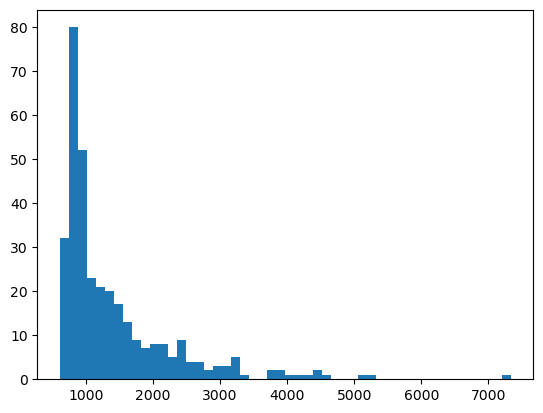

In [6]:
plt.hist([len(v) for k, v in wt_ddg_dict.items()], bins=50)
plt.show()

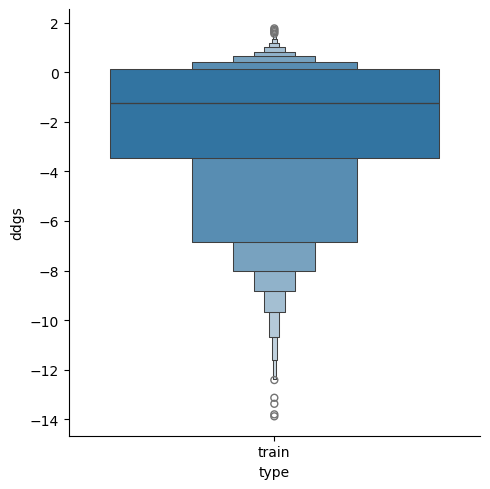

In [11]:
plot_data = pd.DataFrame({'ddgs': wt_ddg_dict['5KPH.pdb'], 'type': ['train']*len(wt_ddg_dict['5KPH.pdb'])})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [12]:
np.quantile(wt_ddg_dict['5KPH.pdb'], [0.9, 0.99, 0.999, 0.9999])

array([0.50681016, 1.14587034, 1.64824947, 1.75861138])

In [32]:
ddgs_list_gt = []
for k, v in wt_ddg_dict.items():
    ddgs_list_gt.extend(v)

dgs_list_gt = []
for k, v in wt_dg_dict.items():
    dgs_list_gt.extend(v)

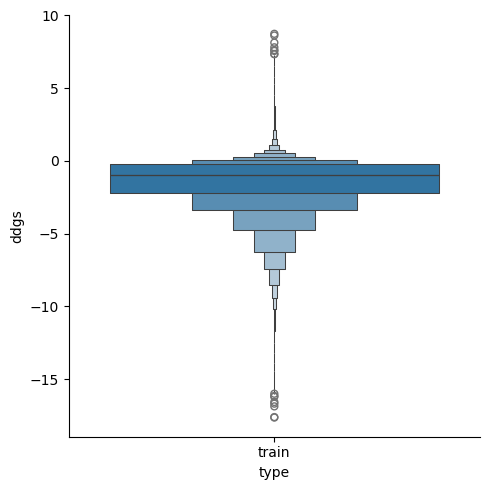

In [8]:
plot_data = pd.DataFrame({'ddgs': ddgs_list_gt, 'type': ['train']*len(ddgs_list_gt)})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [9]:
np.quantile(ddgs_list_gt, [0.9, 0.99, 0.999, 0.9999])

array([0.15331601, 0.96068969, 2.97005428, 5.39591037])

In [13]:
argparser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

argparser.add_argument("--path_for_pdbs", type=str, default="/data/wangc239/proteindpo_data/AlphaFold_model_PDBs", help="path for loading pdb files") 
argparser.add_argument("--path_for_dpo_dicts", type=str, default="/data/wangc239/proteindpo_data/processed_data", help="path for loading ProteinDPO dict files") 

# TODO: modify the outputs logging system and wandb logging
argparser.add_argument("--path_for_outputs", type=str, default="/data/wangc239/protein_oracle/outputs", help="path for logs and model weights")
argparser.add_argument("--previous_checkpoint", type=str, default="", help="path for previous model weights, e.g. file.pt")
argparser.add_argument("--num_epochs", type=int, default=100, help="number of epochs to train for") # 200
argparser.add_argument("--save_model_every_n_epochs", type=int, default=10, help="save model weights every n epochs")
# argparser.add_argument("--reload_data_every_n_epochs", type=int, default=2, help="reload training data every n epochs")
# argparser.add_argument("--num_examples_per_epoch", type=int, default=1000000, help="number of training example to load for one epoch")
argparser.add_argument("--batch_size", type=int, default=32, help="number of sequences for one batch") # 128
# argparser.add_argument("--max_protein_length", type=int, default=10000, help="maximum length of the protein complext")
argparser.add_argument("--hidden_dim", type=int, default=128, help="hidden model dimension")
argparser.add_argument("--num_encoder_layers", type=int, default=3, help="number of encoder layers") 
argparser.add_argument("--num_decoder_layers", type=int, default=3, help="number of decoder layers")
argparser.add_argument("--num_neighbors", type=int, default=30, help="number of neighbors for the sparse graph")   # 48
argparser.add_argument("--dropout", type=float, default=0.1, help="dropout level; 0.0 means no dropout") # TODO
argparser.add_argument("--backbone_noise", type=float, default=0.1, help="amount of noise added to backbone during training")   # TODO
argparser.add_argument("--rescut", type=float, default=3.5, help="PDB resolution cutoff")
argparser.add_argument("--debug", type=str2bool, default=False, help="minimal data loading for debugging")
argparser.add_argument("--gradient_norm", type=float, default=1.0, help="clip gradient norm, set to negative to omit clipping")
argparser.add_argument("--mixed_precision", type=str2bool, default=True, help="train with mixed precision")
argparser.add_argument("--initialize_with_pretrain", type=str2bool, default=False, help="initialize with FMIF weights")
argparser.add_argument("--train_using_diff", type=str2bool, default=False, help="training using difference in dG")

argparser.add_argument("--wandb_name", type=str, default="debug", help="wandb run name")
argparser.add_argument("--lr", type=float, default=1e-4)
argparser.add_argument("--wd", type=float, default=1e-4)

argparser.add_argument("--min_t", type=float, default=1e-2)
argparser.add_argument("--schedule", type=str, default='linear') # other schedule is not implemented
argparser.add_argument("--schedule_exp_rate", type=float, default=-3)
argparser.add_argument("--temp", type=float, default=0.1)
argparser.add_argument("--noise", type=float, default=1.0) # 20.0
argparser.add_argument("--interpolant_type", type=str, default='masking')
argparser.add_argument("--do_purity", type=str2bool, default=False) # True
argparser.add_argument("--num_timesteps", type=int, default=50) # 500
argparser.add_argument("--seed", type=int, default=0)
# argparser.add_argument("--eval_every_n_epochs", type=int, default=20)

argparser.add_argument("--accum_steps", type=int, default=1)
argparser.add_argument("--truncate_steps", type=int, default=10)
argparser.add_argument("--alpha", type=float, default=0.001)
argparser.add_argument("--gumbel_softmax_temp", type=float, default=0.5)

args = argparser.parse_args([])

In [14]:
reward_model = ProteinMPNNOracle(node_features=args.hidden_dim,
                    edge_features=args.hidden_dim,
                    hidden_dim=args.hidden_dim,
                    num_encoder_layers=args.num_encoder_layers,
                    num_decoder_layers=args.num_encoder_layers,
                    k_neighbors=args.num_neighbors,
                    dropout=args.dropout,
                    # augment_eps=args.backbone_noise
                    )
reward_model.cuda()
reward_model.load_state_dict(torch.load('/data/wangc239/protein_oracle/outputs/azLcCvVyTH_20240716_172237/model_weights/epoch10_step37430.pt')['model_state_dict'])
reward_model.eval()

ProteinMPNNOracle(
  (features): ProteinFeatures(
    (embeddings): PositionalEncodings(
      (linear): Linear(in_features=66, out_features=16, bias=True)
    )
    (edge_embedding): Linear(in_features=416, out_features=128, bias=False)
    (norm_edges): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (W_e): Linear(in_features=128, out_features=128, bias=True)
  (W_s): Embedding(22, 128)
  (encoder_layers): ModuleList(
    (0-2): 3 x EncLayer(
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (W1): Linear(in_features=384, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (W3): Linear(in_features=128, out_features=128, bias

### for all training proteins

In [12]:
pdb_path = '/data/wangc239/proteindpo_data/AlphaFold_model_PDBs'
max_len = 75  # Define the maximum length of proteins
dataset = ProteinStructureDataset(pdb_path, max_len) # max_len set to 75 (sequences range from 31 to 74)
loader = DataLoader(dataset, batch_size=1000, shuffle=False)

# make a dict of pdb filename: index
for batch in loader:
    pdb_structures = batch[0]
    pdb_filenames = batch[1]
    pdb_idx_dict = {pdb_filenames[i]: i for i in range(len(pdb_filenames))}
    break
dpo_train_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict.pkl'), 'rb'))
dpo_train_dataset = ProteinDPODataset(dpo_train_dict, pdb_idx_dict, pdb_structures)
loader_train = DataLoader(dpo_train_dataset, batch_size=128, shuffle=False)

In [13]:
device = 'cuda'
ddgs_list = []
for batch in tqdm(loader_train):
    X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, device)
    with torch.no_grad():
        dg_pred = reward_model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
        dg_pred_wt = reward_model(X, S_wt, mask, chain_M, residue_idx, chain_encoding_all)
    ddgs_list.extend((dg_pred - dg_pred_wt).cpu().numpy())

  0%|          | 0/3743 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 3743/3743 [09:54<00:00,  6.29it/s]


In [14]:
np.quantile(ddgs_list, [0.9, 0.99, 0.999, 0.9999])

array([0.01208639, 0.17639442, 0.49483767, 0.90295771])

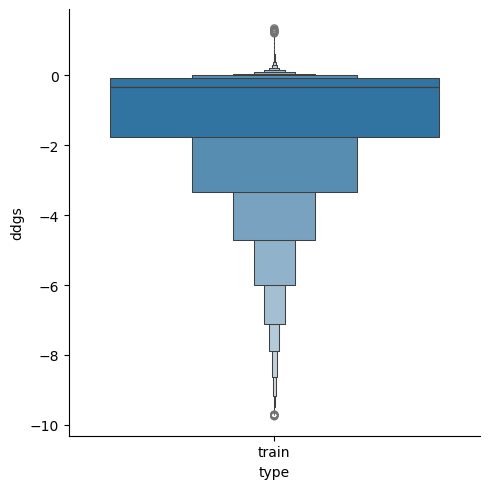

In [15]:
plot_data = pd.DataFrame({'ddgs': ddgs_list, 'type': ['train']*len(ddgs_list)})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

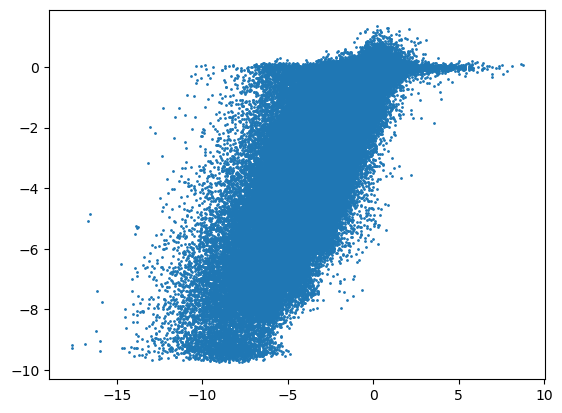

In [16]:
plt.scatter(ddgs_list_gt, ddgs_list, s=1)

In [17]:
# calculate pearson correlation
pearsonr(ddgs_list_gt, ddgs_list)

PearsonRResult(statistic=0.8491055070495943, pvalue=0.0)

### For 5KPH

In [37]:
pdb_path = '/data/wangc239/proteindpo_data/AlphaFold_model_PDBs'
max_len = 75  # Define the maximum length of proteins
dataset = ProteinStructureDataset(pdb_path, max_len) # max_len set to 75 (sequences range from 31 to 74)
loader = DataLoader(dataset, batch_size=1000, shuffle=False)

# make a dict of pdb filename: index
for batch in loader:
    pdb_structures = batch[0]
    pdb_filenames = batch[1]
    pdb_idx_dict = {pdb_filenames[i]: i for i in range(len(pdb_filenames))}
    break
dpo_train_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict.pkl'), 'rb')) # 2388
dpo_train_dict = {k: v for k, v in dpo_train_dict.items() if v[-1] == '5KPH.pdb'}
dpo_train_dataset = ProteinDPODataset(dpo_train_dict, pdb_idx_dict, pdb_structures)
loader_train = DataLoader(dpo_train_dataset, batch_size=128, shuffle=False)

In [38]:
device = 'cuda'
ddgs_list = []
for batch in tqdm(loader_train):
    X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, device)
    with torch.no_grad():
        dg_pred = reward_model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
        dg_pred_wt = reward_model(X, S_wt, mask, chain_M, residue_idx, chain_encoding_all)
    ddgs_list.extend((dg_pred - dg_pred_wt).cpu().numpy())

  0%|          | 0/19 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


In [39]:
dg_pred_wt

tensor([2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168], device='cuda:0')

In [24]:
np.quantile(ddgs_list, [0.9, 0.99, 0.999, 0.9999])

array([3.34739685e-05, 7.17804670e-02, 1.39942981e-01, 1.58393696e-01])

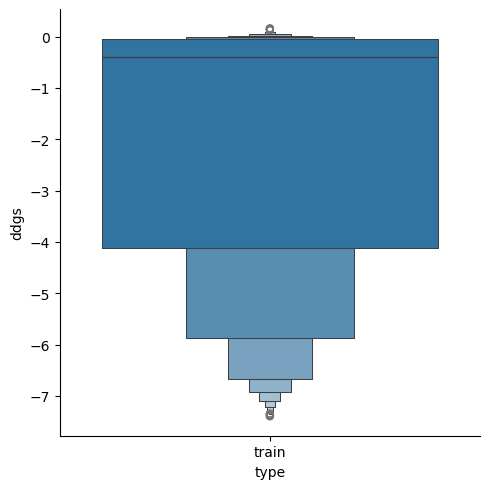

In [25]:
plot_data = pd.DataFrame({'ddgs': ddgs_list, 'type': ['train']*len(ddgs_list)})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

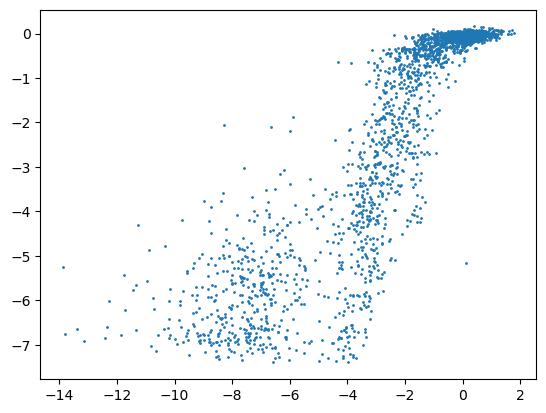

In [26]:
plt.scatter(wt_ddg_dict['5KPH.pdb'], ddgs_list, s=1)

In [27]:
pearsonr(wt_ddg_dict['5KPH.pdb'], ddgs_list)

PearsonRResult(statistic=0.8936289848797632, pvalue=0.0)

### Sampling

In [18]:
dpo_train_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict_wt.pkl'), 'rb'))
dpo_train_dataset_wt = ProteinDPODataset(dpo_train_dict_wt, pdb_idx_dict, pdb_structures)
loader_train_wt = DataLoader(dpo_train_dataset_wt, batch_size=1, shuffle=True)

In [19]:
noise_interpolant = Interpolant(args)
noise_interpolant.set_device(device)

In [20]:
new_fmif_model = ProteinMPNNFMIF(node_features=args.hidden_dim,
                    edge_features=args.hidden_dim,
                    hidden_dim=args.hidden_dim,
                    num_encoder_layers=args.num_encoder_layers,
                    num_decoder_layers=args.num_encoder_layers,
                    k_neighbors=args.num_neighbors,
                    dropout=args.dropout,
                    # augment_eps=args.backbone_noise
                    )
new_fmif_model.to(device)
new_fmif_model.load_state_dict(torch.load('/data/wangc239/pmpnn/outputs/jnvGDJFmCj_20240710_145313/model_weights/epoch300_step447702.pt')['model_state_dict'])

<All keys matched successfully>

In [22]:
N_sample = 100
pred_ddgs_pretrain = []
new_fmif_model.eval()
for batch in tqdm(loader_train_wt):
    X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, device)
    X = X.repeat(N_sample, 1, 1, 1)
    mask = mask.repeat(N_sample, 1)
    chain_M = chain_M.repeat(N_sample, 1)
    residue_idx = residue_idx.repeat(N_sample, 1)
    chain_encoding_all = chain_encoding_all.repeat(N_sample, 1)
    with torch.no_grad():
        S_sp, _, _ = noise_interpolant.sample(new_fmif_model, X, mask, chain_M, residue_idx, chain_encoding_all)
    # dg_ml = batch['dG_ML'].to(dtype=torch.float32, device=device)
    # dg_ml_wt = batch['dG_ML_wt'].to(dtype=torch.float32, device=device)
        # S_wt = S_wt.repeat(N_sample, 1)
        dg_pred = reward_model(X, S_sp, mask, chain_M, residue_idx, chain_encoding_all)
        dg_pred_wt = reward_model(X[[0]], S_wt, mask[[0]], chain_M[[0]], residue_idx[[0]], chain_encoding_all[[0]]).repeat(N_sample)
        pred_ddgs_pretrain.append((dg_pred - dg_pred_wt).detach().cpu().numpy())

100%|██████████| 339/339 [12:41<00:00,  2.25s/it]


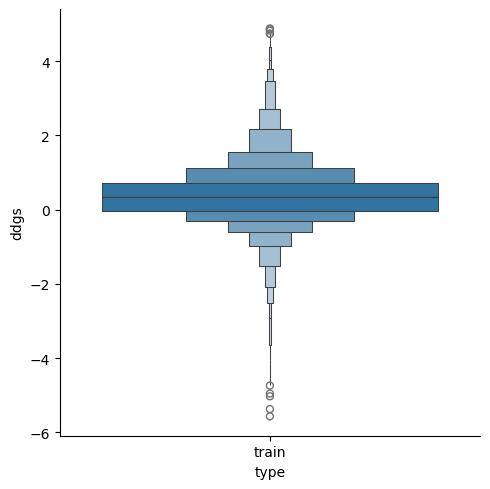

In [28]:
plot_data = pd.DataFrame({'ddgs': np.concatenate(pred_ddgs_pretrain), 'type': ['train']*np.concatenate(pred_ddgs_pretrain).shape[0]})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [29]:
np.concatenate(pred_ddgs_pretrain).mean()

0.38609633

### Sampling 5KPH

In [28]:
dpo_train_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict_wt.pkl'), 'rb'))
dpo_train_dict_wt = {k: v for k, v in dpo_train_dict_wt.items() if v[-1] == '5KPH.pdb'}
dpo_train_dataset_wt = ProteinDPODataset(dpo_train_dict_wt, pdb_idx_dict, pdb_structures)
loader_train_wt = DataLoader(dpo_train_dataset_wt, batch_size=1, shuffle=True)

In [30]:
noise_interpolant = Interpolant(args)
noise_interpolant.set_device(device)

In [31]:
new_fmif_model = ProteinMPNNFMIF(node_features=args.hidden_dim,
                    edge_features=args.hidden_dim,
                    hidden_dim=args.hidden_dim,
                    num_encoder_layers=args.num_encoder_layers,
                    num_decoder_layers=args.num_encoder_layers,
                    k_neighbors=args.num_neighbors,
                    dropout=args.dropout,
                    # augment_eps=args.backbone_noise
                    )
new_fmif_model.to(device)
new_fmif_model.load_state_dict(torch.load('/data/wangc239/pmpnn/outputs/jnvGDJFmCj_20240710_145313/model_weights/epoch300_step447702.pt')['model_state_dict'])

<All keys matched successfully>

In [32]:
N_sample = 100
pred_ddgs_pretrain = []
new_fmif_model.eval()
for batch in tqdm(loader_train_wt):
    X, S, mask, chain_M, residue_idx, chain_encoding_all, S_wt = featurize(batch, device)
    X = X.repeat(N_sample, 1, 1, 1)
    mask = mask.repeat(N_sample, 1)
    chain_M = chain_M.repeat(N_sample, 1)
    residue_idx = residue_idx.repeat(N_sample, 1)
    chain_encoding_all = chain_encoding_all.repeat(N_sample, 1)
    with torch.no_grad():
        S_sp, _, _ = noise_interpolant.sample(new_fmif_model, X, mask, chain_M, residue_idx, chain_encoding_all)
    # dg_ml = batch['dG_ML'].to(dtype=torch.float32, device=device)
    # dg_ml_wt = batch['dG_ML_wt'].to(dtype=torch.float32, device=device)
        # S_wt = S_wt.repeat(N_sample, 1)
        dg_pred = reward_model(X, S_sp, mask, chain_M, residue_idx, chain_encoding_all)
        dg_pred_wt = reward_model(X[[0]], S_wt, mask[[0]], chain_M[[0]], residue_idx[[0]], chain_encoding_all[[0]]).repeat(N_sample)
        pred_ddgs_pretrain.append((dg_pred - dg_pred_wt).detach().cpu().numpy())

  0%|          | 0/1 [00:00<?, ?it/s]/home/wangc239/miniconda3/envs/multiflow/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


In [36]:
batch['dG_ML_wt']

tensor([3.4988], dtype=torch.float64)

In [34]:
dg_pred_wt

tensor([2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168, 2.7168,
        2.7168], device='cuda:0')

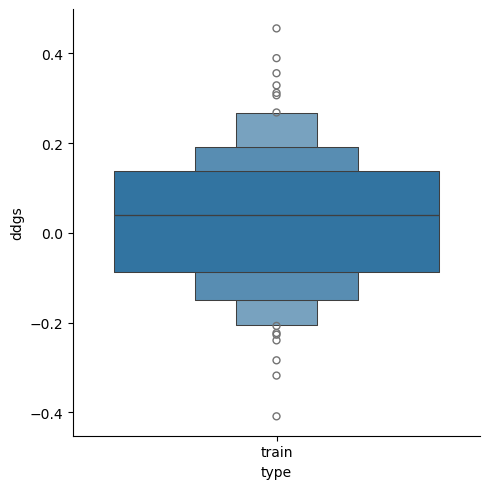

In [33]:
plot_data = pd.DataFrame({'ddgs': np.concatenate(pred_ddgs_pretrain), 'type': ['train']*np.concatenate(pred_ddgs_pretrain).shape[0]})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [2]:
tsu_data = pd.read_csv('/data/wangc239/proteindpo_data/Tsuboyama2023_Dataset2_Dataset3_20230416.csv')

/tmp/ipykernel_3686451/165083596.py:1: DtypeWarning: Columns (30,31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  tsu_data = pd.read_csv('/data/wangc239/proteindpo_data/Tsuboyama2023_Dataset2_Dataset3_20230416.csv')


In [5]:
tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['WT_cluster']==16)]

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
124998,3ZGK.pdb,TCCGCGGGTGGTTCCGGTCCGGGTCTGACCGACCTGTTCAAAACCG...,0.958522,0.983562,0.902448,0.081115,0.095394,-1.567443,3.388609,3.423167,...,GPGLTDLFKTEKAAVKKMAKAIMADPSKADDVYQKWADKGYTLTQL...,wt,3ZGK.pdb,16,0.9585220451028776,-0.0756145584118498,3.555487215177964,-0.0004818511007802506,False,NaN
124999,3ZGK.pdb_wte,TCTGGTCCGGGTCTGACCGACCTGTTCAAAACCGAAAAAGCGGCGG...,0.862605,0.928624,0.815406,0.113218,0.085402,-1.566477,3.255397,3.346121,...,GPGLTDLFKTEKAAVKKMAKAIMADPSKADDVYQKWADKGYTLTQL...,wt,3ZGK.pdb,16,0.8626047236706939,-0.0667081067004428,3.5406043955156785,-0.015364670763065913,False,NaN
125000,3ZGK.pdb_wtm,TCTGGTCCGGGTCTGACCGACCTGTTCAAAACCGAAAAAGCGGCGG...,0.924367,0.987668,0.855437,0.132230,0.076091,-1.566477,3.340262,3.427544,...,GPGLTDLFKTEKAAVKKMAKAIMADPSKADDVYQKWADKGYTLTQL...,wt,3ZGK.pdb,16,0.9243666897871587,-0.0732477447136666,3.4803992367510697,-0.07556982952767477,False,NaN
125001,3ZGK.pdb_wth,TCTGGTCCGGGTCTGACCGACCTGTTCAAAACCGAAAAAGCGGCGG...,0.986783,1.062156,0.948999,0.113157,0.056749,-1.566477,3.426322,3.530731,...,GPGLTDLFKTEKAAVKKMAKAIMADPSKADDVYQKWADKGYTLTQL...,wt,3ZGK.pdb,16,0.9867826895997612,-0.0188278755717254,3.599397192068447,0.043428125789702676,False,NaN
125002,3ZGK.pdb_wty,TCTGGTCCGGGTCTGACCGACCTGTTCAAAACCGAAAAAGCGGCGG...,0.957718,1.003667,0.898581,0.105086,0.047224,-1.566477,3.386207,3.449661,...,GPGLTDLFKTEKAAVKKMAKAIMADPSKADDVYQKWADKGYTLTQL...,wt,3ZGK.pdb,16,0.9577182459435742,0.0481874216410747,3.623168673139217,0.06719960686047255,False,NaN
161602,2LC2.pdb,TCTGCTGGCGGTCGTGGTTTCCTGGAAAAAGCGGCGGTTAAGAAAA...,0.492520,0.543690,0.433837,0.109853,0.099806,-1.423934,2.558080,2.627927,...,RGFLEKAAVKKMAKAIMADPNKADEVYKKWADKGYTLTQMSNFLKS...,wt,2LC2.pdb,16,0.4925204917067005,-0.2850988737440055,3.010530407936141,-0.008239319000979073,False,NaN
161603,2LC2.pdb_wtm,TCTGCGGGTGGTCGTGGTTTCCTGGAAAAAGCGGCGGTTAAAAAGA...,0.379767,0.421983,0.366120,0.055863,0.092925,-1.423934,2.404069,2.461758,...,RGFLEKAAVKKMAKAIMADPNKADEVYKKWADKGYTLTQMSNFLKS...,wt,2LC2.pdb,16,0.3797668752457593,-0.178692463456891,3.0800081850364025,0.06123845809928241,False,NaN
161604,2LC2.pdb_wth,TCTGCTGGTGGTCGTGGTTTCCTGGAAAAAGCGGCGGTTAAGAAAA...,0.351400,0.385315,0.295765,0.089550,0.086116,-1.423934,2.365279,2.411653,...,RGFLEKAAVKKMAKAIMADPNKADEVYKKWADKGYTLTQMSNFLKS...,wt,2LC2.pdb,16,0.3514000356785051,-0.2308968153081513,3.01876972693712,0.0,False,NaN
161605,2LC2.pdb_wty,TCTGCGGGTGGTCGTGGTTTCCTGGAAAAAGCGGCGGTTAAAAAGA...,0.394353,0.424496,0.337827,0.086669,0.062112,-1.423934,2.424006,2.465190,...,RGFLEKAAVKKMAKAIMADPNKADEVYKKWADKGYTLTQMSNFLKS...,wt,2LC2.pdb,16,0.3943534962655691,-0.2207455380168549,3.0217019968079706,0.00293226987085049,False,NaN
161606,2LC2.pdb_wte,TCTGCTGGTGGTCGTGGTTTCCTGGAAAAAGCGGCGGTTAAAAAGA...,0.330311,0.355077,0.256125,0.098952,0.053788,-1.423934,2.336426,2.370309,...,RGFLEKAAVKKMAKAIMADPNKADEVYKKWADKGYTLTQMSNFLKS...,wt,2LC2.pdb,16,0.3303112552667092,-0.1760171873802078,2.995822626326315,-0.022947100610805293,False,NaN


In [42]:
tsu_data['WT_cluster'].value_counts()

WT_cluster
15       80135
EEHH     39361
23       38632
4        34617
EEHEE    27752
         ...  
155        396
30         362
119        342
97         237
148         71
Name: count, Length: 164, dtype: int64

In [45]:
tsu_data.loc[tsu_data['mut_type']=='wt']['WT_cluster'].value_counts()

WT_cluster
15       220
EEHH     189
EEHEE    144
EHEE     140
23       120
        ... 
171        5
147        5
40         5
119        4
145        4
Name: count, Length: 144, dtype: int64

In [46]:
tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['WT_cluster']=='119')]

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
450913,2YSB.pdb,GGTGGTGAAGACCTGCCGCTGCCACCGGGTTGGTCTGTTGACTGGA...,0.346110,0.352902,0.334220,0.018682,0.050774,-1.091191,1.902011,1.911488,...,GEDLPLPPGWSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG,wt,2YSB.pdb,119,0.3461096617864585,-1.2152769700659327,1.8775970603370744,0.0,-,NaN
450914,2YSB.pdb_wty,TCTGCTGGCGGTTCCGCTGGTGGTTCTGCTGGTGGTTCCGCTGGCG...,-0.010999,0.034683,-0.042613,0.077296,0.137747,-1.066458,1.357922,1.424691,...,GEDLPLPPGWSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG,wt,2YSB.pdb,119,-0.0109990755339122,-1.0672233404021805,1.858622831347622,-0.018974228989452335,False,NaN
450915,2YSB.pdb_wth,TCTGCGGGTGGTTCCGCTGGCGGCTCCGCGGGCGGTTCTGCGGGCG...,-0.309866,-0.221522,-0.386479,0.164957,0.218952,-1.066458,0.899648,1.040071,...,GEDLPLPPGWSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG,wt,2YSB.pdb,119,-0.3098655454157263,-1.114802727650597,1.8922242722442049,0.014627211907130455,False,NaN
450916,2YSB.pdb_wte,TCCGCTGGCGGTTCCGCGGGCGGCTCTGCGGGTGGTTCTGCGGGTG...,-0.065653,-0.039934,-0.085386,0.045451,0.163613,-1.066458,1.277164,1.315294,...,GEDLPLPPGWSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG,wt,2YSB.pdb,119,-0.065652798346566,-1.1362560970568458,1.80256498632888,-0.07503207400819445,False,NaN


In [22]:
tsu_proteins = tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['name']==tsu_data['WT_name']), 'name'].unique() # 477
common_proteins = list(set(list(wt_mut_dict_list.keys())) & set(list(tsu_proteins))) # 302

In [37]:
common_dgs_list_gt = []
for k, v in wt_dg_dict.items():
    if k in common_proteins:
        common_dgs_list_gt.extend(v)

In [41]:
np.quantile(common_dgs_list_gt, 0.99)

6.175970293940343

In [69]:
dpo_raw_train = pd.read_csv('/data/wangc239/proteindpo_data/dpo_splits/609k_struct_train_dGML.csv', index_col='Unnamed: 0')
dpo_raw_valid = pd.read_csv('/data/wangc239/proteindpo_data/dpo_splits/22k_struct_valid_ddG_ML.csv', index_col='Unnamed: 0')
dpo_raw_test = pd.read_csv('/data/wangc239/proteindpo_data/dpo_splits/25k_struct_test_ddG_ML.csv', index_col='Unnamed: 0')

In [45]:
dpo_raw_train

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
0,0.01719762915616707,3.332126,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb,wt,EA:run2_0325_0005.pdb,False,3.178183
5,-0.07229644734890961,3.242632,QEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1Q,D1Q,EA:run2_0325_0005.pdb,False,3.242632
6,-0.0676614464832106,3.247267,EEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1E,D1E,EA:run2_0325_0005.pdb,False,3.247267
7,-0.04581499779145215,3.269113,NEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1N,D1N,EA:run2_0325_0005.pdb,False,3.269113
8,-0.08010508773722425,3.234823,HEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1H,D1H,EA:run2_0325_0005.pdb,False,3.234823
...,...,...,...,...,...,...,...,...
776293,-,-2.850140,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRIVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40I,I32P:L40I,9AME.pdb,-,-2.850140
776294,-,-3.924992,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRWVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40W,I32P:L40W,9AME.pdb,-,-3.924992
776295,-,-2.365774,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRYVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40Y,I32P:L40Y,9AME.pdb,-,-2.365774
776296,-,-1.961486,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRFVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40F,I32P:L40F,9AME.pdb,-,-1.961486


In [81]:
dpo_raw_train.loc[(dpo_raw_train['WT_name']=='EA:run2_0325_0005.pdb')]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
0,0.01719762915616707,3.332126,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb,wt,EA:run2_0325_0005.pdb,False,3.178183
5,-0.07229644734890961,3.242632,QEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1Q,D1Q,EA:run2_0325_0005.pdb,False,3.242632
6,-0.0676614464832106,3.247267,EEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1E,D1E,EA:run2_0325_0005.pdb,False,3.247267
7,-0.04581499779145215,3.269113,NEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1N,D1N,EA:run2_0325_0005.pdb,False,3.269113
8,-0.08010508773722425,3.234823,HEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_D1H,D1H,EA:run2_0325_0005.pdb,False,3.234823
...,...,...,...,...,...,...,...,...
1030,-0.10539439308978427,3.209534,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWEW,EA|run2_0325_0005.pdb_R47W,R47W,EA:run2_0325_0005.pdb,False,3.209534
1031,0.04010897971393179,3.355037,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWEY,EA|run2_0325_0005.pdb_R47Y,R47Y,EA:run2_0325_0005.pdb,False,3.355037
1032,-0.00871355984274036,3.306215,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWEF,EA|run2_0325_0005.pdb_R47F,R47F,EA:run2_0325_0005.pdb,False,3.306215
1033,-0.5067396850980659,2.808189,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWEP,EA|run2_0325_0005.pdb_R47P,R47P,EA:run2_0325_0005.pdb,False,2.808189


In [79]:
dpo_raw_train.loc[(dpo_raw_train['WT_name']=='EA:run2_0325_0005.pdb') & (dpo_raw_train['ddG_ML']=='-')]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
537,-,-2.010389,DEVTIHLGDKTIRVDGLDKELLEIDKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L25D,L25D,EA:run2_0325_0005.pdb,False,-2.010389
550,-,-3.376464,DEVTIHLGDKTIRVDGLDKELLEIPKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L25P,L25P,EA:run2_0325_0005.pdb,False,-3.376464
616,-,-1.382612,DEVTIHLGDKTIRVDGLDKELLEILKEPARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L28P,L28P,EA:run2_0325_0005.pdb,False,-1.382612


In [75]:
dpo_raw_train.loc[dpo_raw_train['dG_ML'] < -1]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
537,-,-2.010389,DEVTIHLGDKTIRVDGLDKELLEIDKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L25D,L25D,EA:run2_0325_0005.pdb,False,-2.010389
550,-,-3.376464,DEVTIHLGDKTIRVDGLDKELLEIPKELARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L25P,L25P,EA:run2_0325_0005.pdb,False,-3.376464
616,-,-1.382612,DEVTIHLGDKTIRVDGLDKELLEILKEPARRGADEEELRKEIERWER,EA|run2_0325_0005.pdb_L28P,L28P,EA:run2_0325_0005.pdb,False,-1.382612
7114,-,-1.257666,DRHTIHIGDITIHLEGFSEEELKLAEELIKRGIHLEEVKRIPEELYR,EA|run7_1572_0002.pdb_L42P,L42P,EA:run7_1572_0002.pdb,False,-1.257666
11926,-,-1.041241,LTVEVTLDGRRIELHGLSEEAHEIKRHALERNADDKEIKKILEELRK,GG|run4_0467_0002.pdb_L25K,L25K,GG:run4_0467_0002.pdb,False,-1.041241
...,...,...,...,...,...,...,...,...
776293,-,-2.850140,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRIVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40I,I32P:L40I,9AME.pdb,-,-2.850140
776294,-,-3.924992,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRWVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40W,I32P:L40W,9AME.pdb,-,-3.924992
776295,-,-2.365774,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRYVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40Y,I32P:L40Y,9AME.pdb,-,-2.365774
776296,-,-1.961486,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRFVGMQVN...,9AME.pdb_dmutv5_32I:40L_I32P:L40F,I32P:L40F,9AME.pdb,-,-1.961486


In [61]:
dpo_raw_train.loc[dpo_raw_train['WT_name']=='1IGD.pdb']

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
554551,-,5.218107,VTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTY...,1IGD.pdb,wt,1IGD.pdb,-,5.218107
554556,-,5.458468,QTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTY...,1IGD.pdb_V1Q,V1Q,1IGD.pdb,-,5.458468
554557,-,5.389146,ETTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTY...,1IGD.pdb_V1E,V1E,1IGD.pdb,-,5.389146
554558,-,5.045987,NTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTY...,1IGD.pdb_V1N,V1N,1IGD.pdb,-,5.045987
554559,-,5.217623,HTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTY...,1IGD.pdb_V1H,V1H,1IGD.pdb,-,5.217623
...,...,...,...,...,...,...,...,...
754867,-,-3.167643,VTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTP...,1IGD.pdb_dmutv5_46Y:53F_Y46P:F53V,Y46P:F53V,1IGD.pdb,-,-3.167643
754868,-,-3.261665,VTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTP...,1IGD.pdb_dmutv5_46Y:53F_Y46P:F53I,Y46P:F53I,1IGD.pdb,-,-3.261665
754869,-,-0.841262,VTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTP...,1IGD.pdb_dmutv5_46Y:53F_Y46P:F53W,Y46P:F53W,1IGD.pdb,-,-0.841262
754870,-,-1.589738,VTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTP...,1IGD.pdb_dmutv5_46Y:53F_Y46P:F53Y,Y46P:F53Y,1IGD.pdb,-,-1.589738


In [68]:
dpo_raw_train.loc[(dpo_raw_train['name'].isin(list(wt_mut_dict_list.keys()))) & (dpo_raw_train['dG_ML']>5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
475839,-,6.267312,RLKGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQA...,2I5L.pdb,wt,2I5L.pdb,-,6.267312
490764,-,5.233887,KELVLVLYDYQEKSPRELTVKKGDILTLLNSTNKDWWKIEVNGRQG...,3NGP.pdb,wt,3NGP.pdb,-,5.233887
492000,-,5.324252,KVLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,6RO9.pdb,wt,6RO9.pdb,-,5.324252
495777,-,5.024433,VTLFVALYDYEAITEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,6IPY.pdb,wt,6IPY.pdb,-,5.024433
510477,-,5.756481,AQASVVANQLIPINTRLTLVMMRSEVVTPVGIPAEDIPALVSMQVN...,6MSI.pdb,wt,6MSI.pdb,-,5.756481
511888,-,5.886658,NQASVVANQLIPINVALTLVMMRSEVVTPVGIPAEDIPRLVSMQVN...,1MSJ.pdb,wt,1MSJ.pdb,-,5.886658
513300,-,6.049567,NQASVVANQLIPINTALTLAMMRSEVVTPVGIPAEDIPRLVSMQVN...,1B7J.pdb,wt,1B7J.pdb,-,6.049567
516102,-,5.836739,NQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVGMQVN...,9AME.pdb,wt,9AME.pdb,-,5.836739
518949,-,6.323694,AQASVVANQLIPINTYLTLVMMRSEVVTPVGIPAEDIPRLVSMQVN...,7MSI.pdb,wt,7MSI.pdb,-,6.323694
520362,-,5.936314,NQASVVANQLIPISTALTLVMMRSEVVTPVGIPAEDIPRLVSMTVN...,8MSI.pdb,wt,8MSI.pdb,-,5.936314


In [71]:
dpo_raw_valid.loc[(dpo_raw_valid['name']==dpo_raw_valid['WT_name'])]# & (dpo_raw_valid['dG_ML']>5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
129567,-0.028266,0.985102,HEFRDEISVLKANNPHFDKIFEKHNQLDDDIKTAEQQNASDAEVSH...,1ZHC.pdb,wt,1ZHC.pdb,False,1.062394
164428,0.000000,2.236670,TYTWNTKEEAKQAFKELLKEKRVPSNASWEQAMKMIINDPRYSALA...,1UZC.pdb,wt,1UZC.pdb,False,2.253193
176919,0.097095,1.722112,KEFRPGDKVVLPPYGVGVVAGIAQRSVSGVSRAYYQVDFPGSRSKA...,2LQK.pdb,wt,2LQK.pdb,False,1.622017
185109,0.222134,2.625597,HHGSGALAALHADGPHAGLPVTRSDARVLIFNDWEERKRSEPWLRL...,2MCK.pdb,wt,2MCK.pdb,-,2.469439
234437,0.000000,4.220052,TVKFKYKGEEKQVDISKIKKVWRVGKMISFTYDEGGGKTGRGAVSE...,1JIC.pdb,wt,1JIC.pdb,False,4.205819
265837,0.094050,1.773280,SADYSSLTVVQLKDLLTKRNLSVGGLKNEWVQRLIKDDEES,2WQG.pdb,wt,2WQG.pdb,False,1.726158
376825,-0.316340,2.302730,SPEEIKAKALDLLNKKLHRANKFGQDQADIDSLQRQINRVEKFGVD...,v2_4UZX.pdb,wt,v2_4UZX.pdb,False,2.556766
396961,-0.048196,2.790591,SADYSSLTVVQLKDLLTKRNLSVGGLKNELVQRLIKDDEESKGE,4UZW.pdb,wt,4UZW.pdb,False,2.856979
429790,0.060347,3.661558,HHHHHGSGALAALHAEGPLAGLPVTRSDARVLIFNEWEERKKSDPW...,2MCH.pdb,wt,2MCH.pdb,False,3.542387


In [72]:
dpo_raw_valid.loc[(dpo_raw_valid['mut_type']=='wt')]# & (dpo_raw_valid['dG_ML']>5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
129567,-0.028266,0.985102,HEFRDEISVLKANNPHFDKIFEKHNQLDDDIKTAEQQNASDAEVSH...,1ZHC.pdb,wt,1ZHC.pdb,False,1.062394
164428,0.000000,2.236670,TYTWNTKEEAKQAFKELLKEKRVPSNASWEQAMKMIINDPRYSALA...,1UZC.pdb,wt,1UZC.pdb,False,2.253193
176919,0.097095,1.722112,KEFRPGDKVVLPPYGVGVVAGIAQRSVSGVSRAYYQVDFPGSRSKA...,2LQK.pdb,wt,2LQK.pdb,False,1.622017
185109,0.222134,2.625597,HHGSGALAALHADGPHAGLPVTRSDARVLIFNDWEERKRSEPWLRL...,2MCK.pdb,wt,2MCK.pdb,-,2.469439
234437,0.000000,4.220052,TVKFKYKGEEKQVDISKIKKVWRVGKMISFTYDEGGGKTGRGAVSE...,1JIC.pdb,wt,1JIC.pdb,False,4.205819
265837,0.094050,1.773280,SADYSSLTVVQLKDLLTKRNLSVGGLKNEWVQRLIKDDEES,2WQG.pdb,wt,2WQG.pdb,False,1.726158
324711,0.000000,3.073411,MQGVVKVNSALNMRSGPGSNYGVIGTLRNNDKVEIIKEVDGAYEIR...,2KRS.pdb_W42A,wt,2KRS.pdb,False,3.056207
326098,-0.071952,2.442280,MQGVVKVNSALNMRSGPGSNYGVIGTLRNNDKVEIIKEVDGWYEIR...,2KRS.pdb_Y53S,wt,2KRS.pdb,False,2.496740
327488,-0.036311,3.494454,AEKTGIVNVSSSLNVREGASTSSKVIGSLSGNTKVTIVGEEGAFYK...,2KT8.pdb_G54S,wt,2KT8.pdb,False,3.524885
328967,0.073359,2.184647,AEKTGIVNVSSSLNAREGASTSSKVIGSLSGNTKVTIVGEEGAFYK...,2KT8.pdb_V15A,wt,2KT8.pdb,False,2.124580


In [73]:
dpo_raw_test.loc[(dpo_raw_test['mut_type']=='wt')]# & (dpo_raw_valid['dG_ML']>5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
4141,0.192780,4.381241,TEVDLHLGDITIKLKDVSEEIVKRAKELFKNGWSAEFVKKWIEEAVK,EA|run5_0050_0004.pdb,wt,EA:run5_0050_0004.pdb,False,4.221573
29008,0.000000,1.922152,DDVELRDGDWRVELKDADEEILRAVEEAIKNGASEQELRELAERLIR,XX|run7_0974_0003.pdb,wt,XX:run7_0974_0003.pdb,False,1.848788
44080,-0.061613,3.270606,AKPPKTVTVKVEVTNADGETQTRTVTLTNLPKDLKPGDTVTLPETG...,r6_560_TrROS_Hall.pdb,wt,r6_560_TrROS_Hall.pdb,False,3.356751
84615,-0.190784,2.159707,DEEIEKWIETLLKRNISLRVNGKDLEIGSEEFKEWVEKFIKEV,HEEH_KT_rd6_0746.pdb,wt,HEEH_KT_rd6_0746.pdb,False,2.379200
115798,-0.021437,2.384812,HAATELTPEQAAALKPYDRIVITGRFNAIGDAVSAVSRRADEEGAA...,2M2J.pdb,wt,2M2J.pdb,False,2.402419
117365,0.347774,2.902289,AEIMKKTDFDKVASEYTKIGTISTTGEMSPLDAREDLIKKADEKGA...,2MA4.pdb,wt,2MA4.pdb,-,2.692682
148743,-0.111080,4.297936,SFNTVDEWLEAIKMGQYKESFANAGFTSFDVVSQMMMEDILRVGVT...,1F0M.pdb,wt,1F0M.pdb,False,4.394769
199499,0.081427,3.918041,FSITQFVRNLGLEHLMDIFEREQITLRVLVEMGHKELKEIGINAYG...,5JRT.pdb,wt,5JRT.pdb,False,3.864822
214727,0.000000,2.821443,RPMNAFMVWARIHRPALAKANPAANNAEISVQLGLEWNKLSEEQKK...,7JJK.pdb,wt,7JJK.pdb,False,2.830952
239219,-0.040855,3.740629,ELSWTAEAEKMLGKVPFFVRKKVRKNTDNYAREIGEPVVTADVFRK...,2KRU.pdb,wt,2KRU.pdb,False,3.772244


In [66]:
dpo_raw_train.loc[(dpo_raw_train['name'].isin(list(wt_mut_dict_list.keys()))) & (dpo_raw_train['dG_ML']<-1)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG


In [82]:
dpo_raw_train.loc[(dpo_raw_train['name'].isin(list(wt_mut_dict_list.keys()))) & (dpo_raw_train['dG_ML']<5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
33147,0.016723472608110246,2.643030,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,r10_437_TrROS_Hall.pdb,wt,r10_437_TrROS_Hall.pdb,False,2.637182
34181,0.01202518738268532,2.882511,MLYVKVKTEDGEELVLEVEGMTEDEIREELAKAGFKIEEIEVYEVEP,r10_572_TrROS_Hall.pdb,wt,r10_572_TrROS_Hall.pdb,False,2.872365
35213,0.07243192639921414,3.316627,KTYTFRVRIVDEETGEEKEIEVTAKSEEEAKKAAEELKKKYPNLKVELE,r11_233_TrROS_Hall.pdb,wt,r11_233_TrROS_Hall.pdb,False,3.256698
36296,-0.08282852948832642,1.808136,MKVTIEENEETGKFTIKVKTEDGEEKTIEIPKENLEEILAKLPPNVEII,r11_569_TrROS_Hall.pdb,wt,r11_569_TrROS_Hall.pdb,False,1.919491
37378,0.07780996552412356,3.445311,EKTLKIVADSEEEAEALAKELAEKYNLEVTIERNPEEEGKYVITIKIKP,r11_797_TrROS_Hall.pdb,wt,r11_797_TrROS_Hall.pdb,False,3.377271
...,...,...,...,...,...,...,...,...
493237,-,4.778523,KYLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb,wt,5FW9.pdb,-,4.787342
504144,-,4.811454,SPEELKGIFEKYAAKEGDPNQLSKEELKLLLQTEFPSLLKGPSTLD...,1IGV.pdb,wt,1IGV.pdb,-,4.876377
508888,-,4.598490,PVYLSVKADNSMFIGNDPVTDETMITALNALTEGKKDTTIFFRADK...,2PFU.pdb,wt,2PFU.pdb,-,4.720284
538787,-,4.283391,MQIFVKGLTGKTTTLEVEPSDTIENVKAKIQDKTGLPPDQQRLIFA...,2M0X.pdb,wt,2M0X.pdb,-,4.667093


In [84]:
dpo_raw_train.loc[(dpo_raw_train['WT_name']=='5FW9.pdb') & (dpo_raw_train['dG_ML']>5)]

,ddG_ML,dG_ML,aa_seq,name,mut_type,WT_name,Stabilizing_mut,deltaG
493248,-,5.008761,TYLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_K1T,K1T,5FW9.pdb,-,5.008761
493264,-,5.047518,KQLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_Y2Q,Y2Q,5FW9.pdb,-,5.047518
493271,-,5.007749,KTLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_Y2T,Y2T,5FW9.pdb,-,5.007749
493278,-,5.222170,KILVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_Y2I,Y2I,5FW9.pdb,-,5.222170
493282,-,5.202659,KCLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_Y2C,Y2C,5FW9.pdb,-,5.202659
493301,-,5.098434,KYYVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_L3Y,L3Y,5FW9.pdb,-,5.098434
493302,-,5.000962,KYFVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_L3F,L3F,5FW9.pdb,-,5.000962
493320,-,5.247776,KYLLLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_V4L,V4L,5FW9.pdb,-,5.247776
493342,-,5.034034,KYLVVALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_L5V,L5V,5FW9.pdb,-,5.034034
493343,-,5.209213,KYLVIALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,5FW9.pdb_L5I,L5I,5FW9.pdb,-,5.209213


In [117]:
tsu_data.loc[tsu_data['WT_name']=='3DKM.pdb']

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
111033,3DKM.pdb,TCCGCTGGTGGCAACCTCTACTTCCAGGGTCTGAAATACATGGTGC...,0.873456,0.893782,0.826958,0.066824,0.053434,-1.456179,3.122373,3.150317,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,wt,3DKM.pdb,163,0.8734555920487248,-0.3392881061023177,3.115544271860607,0.6467119212390542,-,NaN
111034,3DKM.pdb_wte,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGCG...,0.377778,0.391423,0.361034,0.030389,0.034944,-1.452214,2.439704,2.458336,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,wt,3DKM.pdb,163,0.3777782777789136,-0.8902230423412945,2.4582384989607737,-0.010593851660778864,False,NaN
111035,3DKM.pdb_wth,AACCTGTACTTCCAGGGTCTGAAATACATGGTGCCGGGTGCTCGTG...,0.365208,0.408840,0.324263,0.084577,0.045616,-1.452214,2.422535,2.482115,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,wt,3DKM.pdb,163,0.3652084245513086,-0.8874495769500115,2.449335768974893,-0.01949658164665946,False,NaN
111036,3DKM.pdb_wty,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGTG...,0.422846,0.442967,0.400679,0.042288,0.035603,-1.452214,2.501233,2.528690,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,wt,3DKM.pdb,163,0.4228463966098814,-0.9035919050650832,2.461207111586238,-0.007625239035314646,False,NaN
111037,3DKM.pdb_wtm,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGTG...,0.393485,0.405955,0.370929,0.035026,0.041219,-1.452214,2.461152,2.478177,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,wt,3DKM.pdb,163,0.3934852856592937,-0.8432640023055895,2.4764575896568672,0.007625239035314646,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705009,3DKM.pdb_hnet3_4x_E63P:D67I,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCGGGTGCTCGTG...,-1.706841,-1.612225,-1.812114,0.199889,0.079259,-1.560752,-15.000000,-5.000000,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,E63P:D67I,3DKM.pdb,163,-1.7068408106263813,-2.624796660686984,<-1,-,False,3DKM.pdb_hnet3_4x_|E63X|D67Z
705010,3DKM.pdb_hnet3_4x_E63P:D67W,AACCTGTACTTCCAGGGTCTGAAATACATGGTGCCAGGTGCGCGTG...,-1.675345,-1.569053,-1.766838,0.197785,0.079757,-1.597988,-15.000000,-1.551554,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,E63P:D67W,3DKM.pdb,163,-1.6753446851483105,-2.462983592098787,-0.3829139353778637,-2.8517462859994165,False,3DKM.pdb_hnet3_4x_|E63X|D67Z
705011,3DKM.pdb_hnet3_4x_E63P:D67Y,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCAGGTGCGCGCG...,-1.633433,-1.560804,-1.691658,0.130854,0.073541,-1.569103,-15.000000,-2.289821,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,E63P:D67Y,3DKM.pdb,163,-1.6334326645164026,-2.67451197059592,<-1,-,False,3DKM.pdb_hnet3_4x_|E63X|D67Z
705012,3DKM.pdb_hnet3_4x_E63P:D67F,AACCTGTACTTCCAGGGTCTGAAATACATGGTTCCGGGTGCGCGTG...,-1.402570,-1.275250,-1.493795,0.218545,0.094425,-1.585159,-0.376299,0.023576,...,NLYFQGLKYMVPGARVTRGLDWKWRDQDGSPQGEGTVTGELHNGWI...,E63P:D67F,3DKM.pdb,163,-1.402570067008344,-2.506090864919065,-0.215642703982385,-2.6844750546039378,False,3DKM.pdb_hnet3_4x_|E63X|D67Z


In [46]:
tsu_data

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
0,EA|run2_0325_0005.pdb,TCTGCTGGCGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,1.227105,1.255092,1.197643,0.057449,0.063626,-0.997071,2.998711,3.038485,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2271050771597385,1.2135682995736825,3.3321258839433834,0.01719762915616707,False,NaN
1,EA|run2_0325_0005.pdb_wtm,TCCGCGGGTGGTTCCGCTGGCGGTTCTGCGGGCGGTGACGAAGTTA...,1.297559,1.381800,1.243835,0.137965,0.092264,-0.997071,3.099109,3.220506,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2975591020191513,1.2201805304541726,3.3998316632160224,0.08490340842880606,False,NaN
2,EA|run2_0325_0005.pdb_wte,TCCGCTGGTGGCTCTGCGGGCGGTTCTGCTGGTGGCGACGAAGTTA...,1.262708,1.314787,1.239876,0.074911,0.092305,-0.997071,3.049332,3.123805,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2627076164958364,1.169472475788951,3.315782210420261,0.0008539556330444675,False,NaN
3,EA|run2_0325_0005.pdb_wty,TCCGCTGGTGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,1.244782,1.314467,1.195005,0.119462,0.074537,-0.997071,3.023818,3.123346,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2447822859698547,1.1543165166325822,3.272933265369934,-0.04199498941728219,False,NaN
4,EA|run2_0325_0005.pdb_wth,TCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCG...,0.998142,1.134508,0.723845,0.410663,0.315576,-1.010140,2.694897,2.885558,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,0.9981417661631856,0.6573573370630326,2.570241917260095,-0.7446863375271211,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776293,9AME.pdb_dmutv5_32I:40L_I32P:L40I,TCCGCGGGTGGCTCTGCTGGCGGCAACCAGGCGTCTGTTGTTGCGA...,-1.307630,-1.215993,-1.452696,0.236704,0.066656,-1.370583,-1.077540,-0.492711,...,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRIVGMQVN...,I32P:L40I,9AME.pdb,23,-1.3076297070150713,-2.396316795278767,<-1,-,-,9AME.pdb_dmutv5_32I:40L
776294,9AME.pdb_dmutv5_32I:40L_I32P:L40W,TCCGCGGGTGGTTCTGCGGGCGGTAATCAGGCGTCTGTTGTTGCGA...,-1.428440,-1.346840,-1.516532,0.169692,0.029102,-1.361836,-15.000000,-1.942130,...,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRWVGMQVN...,I32P:L40W,9AME.pdb,23,-1.4284401008427623,-2.4744854593420205,<-1,-,-,9AME.pdb_dmutv5_32I:40L
776295,9AME.pdb_dmutv5_32I:40L_I32P:L40Y,TCTGCGGGCGGTTCTGCTGGTGGTAACCAGGCGTCTGTTGTTGCGA...,-1.308386,-1.197351,-1.425551,0.228200,0.039466,-1.343090,-1.442171,-0.533154,...,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRYVGMQVN...,I32P:L40Y,9AME.pdb,23,-1.3083863512652174,-2.508084984884412,<-1,-,-,9AME.pdb_dmutv5_32I:40L
776296,9AME.pdb_dmutv5_32I:40L_I32P:L40F,TCCGCGGGTGGCTCCGCTGGTGGTAATCAGGCGTCTGTTGTTGCGA...,-1.304723,-1.230693,-1.348690,0.117997,0.050706,-1.359055,-1.168845,-0.619013,...,NQASVVANQLIPINTALTLVMMRSEVVTPVGPPAEDIPRFVGMQVN...,I32P:L40F,9AME.pdb,23,-1.304722632431268,-2.4399613488704723,<-1,-,-,9AME.pdb_dmutv5_32I:40L


In [58]:
set(tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['name']==tsu_data['WT_name']) & (tsu_data['dG_ML']=='>5'), 'name'].unique()) & set(dpo_raw_train['name'].unique())

{'1B7J.pdb',
 '1EKL.pdb',
 '1IGD.pdb',
 '1MSJ.pdb',
 '1PGA.pdb_pross9',
 '1UBQ.pdb_pross7',
 '2AME.pdb',
 '2I5L.pdb',
 '2MSG.pdb',
 '2MSJ.pdb',
 '2N9L.pdb',
 '3AME.pdb',
 '3NGP.pdb',
 '3QF6.pdb',
 '4AME.pdb',
 '4UR4.pdb',
 '5ZD0.pdb',
 '6AME.pdb',
 '6IPY.pdb',
 '6MSI.pdb',
 '6NJF.pdb',
 '6RO9.pdb',
 '6XQC.pdb',
 '7MSI.pdb',
 '8AME.pdb',
 '8MSI.pdb',
 '9AME.pdb',
 'XX|run8_1203_0001.pdb',
 'r14_263_TrROS_Hall.pdb',
 'v2_5XK5.pdb'}

In [56]:
tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['name']==tsu_data['WT_name']) & (tsu_data['dG_ML']=='>5')]

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
475839,2I5L.pdb,TCCGCGGGTCGTCTGAAAGGTAAAGTGAAGTGGTTCAACTCTGAAA...,2.537286,2.592317,2.485342,0.106975,0.085527,-0.972470,15.000000,25.000000,...,RLKGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQA...,wt,2I5L.pdb,105,>2.25,>1.75,>5,-,-,NaN
477295,2LSS.pdb,TCTGCGACCAACATCGTTGGCAAGGTTAAATGGTACAACTCCACCA...,2.088536,2.140357,2.026496,0.113861,0.099118,-1.223772,4.707845,4.825608,...,ATNIVGKVKWYNSTKNFGFIEQDNGGKDVFVHKSAVDAAGLHSLEE...,wt,2LSS.pdb,105,2.0885355218613717,>1.75,>5,-,-,NaN
478816,1MJC.pdb,TCTGCTGGTAAAATGACTGGTATCGTTAAATGGTTCAACGCGGACA...,2.504445,2.587161,2.396254,0.190906,0.056904,-0.982895,15.000000,25.000000,...,GKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEG...,wt,1MJC.pdb,105,>2.25,1.478844923455097,>5,-,-,NaN
485968,2M7O.pdb,TCCGCGGGTGGTTCTGCGATGAAAACCCAGGAAGAACTGACCGAAA...,1.854479,1.870026,1.829872,0.040154,0.071701,-0.597032,3.420668,3.447715,...,MKTQEELTEIVRDHFSDMGEIATLYVQVYESSLESLVGGVIFEDGR...,wt,2M7O.pdb,117,1.85447906362337,1.185887856988753,>5,-,-,NaN
488224,1S1N.pdb,TCCGCGGGTGGTTCTGCTACCGGCGAAGAATACATCGCTGTTGGTG...,1.920033,1.962712,1.893976,0.068736,0.086249,-0.935135,3.989298,4.068155,...,TGEEYIAVGDFTAQQVGDLTFKKGEILLVIEKKPDGWWIAKDAKGN...,wt,1S1N.pdb,15,1.920032742067918,1.5217485793026002,>5,-,-,NaN
490764,3NGP.pdb,TCCGCGGGTGGTTCTGCTGGCGGCAAAGAACTGGTGCTCGTTCTGT...,2.298192,2.388486,2.230860,0.157626,0.081355,-1.232567,5.289221,5.697197,...,KELVLVLYDYQEKSPRELTVKKGDILTLLNSTNKDWWKIEVNGRQG...,wt,3NGP.pdb,15,>2.25,1.3264774508934116,>5,-,-,NaN
492000,6RO9.pdb,TCTGCGGGCGGTTCTGCTGGCGGTAAAGTGCTGGTTCTCGCGCTGT...,2.303811,2.490023,2.253020,0.237003,0.116901,-1.253532,5.337645,7.194671,...,KVLVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEVNGRQG...,wt,6RO9.pdb,15,>2.25,1.3655278258669865,>5,-,-,NaN
494474,5ECA.pdb,TCCGCTGGTGGTTCTGCTGGCGGCTCCGCTCACATGACCTTCGTTG...,1.839310,1.864373,1.814781,0.049593,0.113629,-1.021743,3.963076,4.006303,...,HMTFVALYDYVASGETDLSFKKGERLQIVNNTEGDWWLAHSLTTGR...,wt,5ECA.pdb,15,1.8393100771078963,1.1564083420865692,>5,-,-,NaN
495777,6IPY.pdb,TCTGCTGGCGGTTCTGCTGTTACCCTGTTCGTTGCGCTGTACGACT...,1.964654,1.989904,1.936089,0.053815,0.093995,-0.994718,4.151481,4.199704,...,VTLFVALYDYEAITEDDLSFHKGEKFQILNSSEGDWWEARSLTTGE...,wt,6IPY.pdb,15,1.9646538179760336,1.2409747654016663,>5,-,-,NaN
497080,2ROT.pdb,TCTGCGGGTGGTTCTATGGACGAAACCGGTAAAGAACTGGTGCTCG...,1.906906,1.928931,1.888061,0.040871,0.064620,-1.194624,4.312535,4.352405,...,MDETGKELVLALYDYQEKSPREVTMKKGDILTLLNSTNKDWWKVEV...,wt,2ROT.pdb,15,1.9069061724348604,1.1130888926438192,>5,-,-,NaN


In [51]:
wtcount = tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['name']==tsu_data['WT_name'])]['WT_cluster'].value_counts()

In [66]:
tsu_data.loc[(tsu_data['mut_type']=='wt') & (tsu_data['name']==tsu_data['WT_name']) & (tsu_data['WT_cluster']=='HHH')]

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
92159,HHH_rd1_0244.pdb,GGCCAGGAGGAAGAGAAAGAAATCAAACGTCTGGCGAAAAAGTTCA...,0.876105,0.964957,0.810792,0.154165,0.071871,-1.164823,2.734310,2.857172,...,QEEEKEIKRLAKKFNASEEEARRAWKKAGGDPETAEKILKKKG,wt,HHH_rd1_0244.pdb,HHH,0.8761045397438332,-0.0097081465786278,2.8478259374557475,-0.15461669927243982,False,NaN
93098,HHH_rd1_0335.pdb,GGTACCGAAGACGAAAAGAAAATCCAGGAACTGCTGAAACGTGCGA...,0.241247,0.254438,0.219787,0.034651,0.038494,-1.252932,1.979788,1.998077,...,TEDEKKIQELLKRANGDVSKAEKLAQSQGNEELARRLREYANK,wt,HHH_rd1_0335.pdb,HHH,0.2412473720625088,-0.2709268929102755,2.1504287451444317,-0.3220671153095025,False,NaN
94044,HHH_rd1_0473.pdb,GGCCAGAAGGAAGAACTGAAAGAAAAAGCGAAAGAAGCGGTTAAAC...,0.227749,0.249535,0.214317,0.035218,0.046620,-1.077008,1.716120,1.746854,...,QKEELKEKAKEAVKRGNKDKARELLKRAGISEEEAKKIIKKIE,wt,HHH_rd1_0473.pdb,HHH,0.2277490745504178,0.0361876005628393,1.7818910676815327,0.061027718845606094,False,NaN
94993,HHH_rd1_0516.pdb,GGTGACGAAGACTCTGAACGTGAACTGGAAAAACTGCGCAAAAACA...,-0.058410,-0.045736,-0.070586,0.024850,0.050139,-0.933557,1.087382,1.106916,...,DEDSERELEKLRKNNASKEEIKEVLKRLGFSEDEAKKLAEKAG,wt,HHH_rd1_0516.pdb,HHH,-0.058410427251736,-0.008305520885605,1.3385190134880245,-0.3540313716583976,False,NaN
95925,HHH_rd1_0598.pdb,GGTACCGAAGACGCGCGCAAAGAAGCGAAGAAAATCATCGACAACG...,-0.304408,-0.289416,-0.326321,0.036905,0.036975,-1.164352,1.063197,1.086394,...,TEDARKEAKKIIDNGGSPDEAAKFIKKYGLSEDQARELVKRAL,wt,HHH_rd1_0598.pdb,HHH,-0.304408058034179,-1.1880084243577878,1.2352720886386246,-0.15688635503270443,False,NaN
96865,HHH_rd1_0606.pdb,GGTCCGGATGACGAATGGAAAGAACGTCTGCGTGAAGCGGAGGAAA...,0.522987,0.550929,0.501487,0.049443,0.061453,-1.287571,2.415105,2.453401,...,PDDEWKERLREAEEKNNWKLFEELARKAGVSEEKIEEWKRRWS,wt,HHH_rd1_0606.pdb,HHH,0.5229866308838005,-0.044771234352082,2.8212171509090487,-0.4092218350773891,False,NaN
97800,HHH_rd1_0949.pdb,GGCTCTGAAGAGAAGAAAAAAGCGAAAGAGCGTCTGGAACGTCTGG...,0.458569,0.507420,0.436394,0.071026,0.118523,-1.344241,2.403743,2.470603,...,SEEKKKAKERLERLGASSELARELLDRANGNAEKAERLLRKLL,wt,HHH_rd1_0949.pdb,HHH,0.4585691442671095,0.1875249017612333,2.314994116214909,-0.0020237296213418965,False,NaN
98740,HHH_rd2_0181.pdb,TCTGCGGGCGGTTCTGCTGGTGGCTCTGCGGGTGGTTCTGCTGGCC...,1.164519,1.386861,0.948726,0.438135,0.346460,-1.091640,3.037301,3.354620,...,PKDQAKKEIEKALRNGDEEKAKRLAKKYGISDDDWKELKKRVS,wt,HHH_rd2_0181.pdb,HHH,1.1645190743346396,0.7220450512534111,3.415174777455558,-0.44440971292171705,False,NaN
99685,HHH_rd4_0124.pdb,TCCGCGGGCGGTTCCGCTGGCGGCTCTGCGGGTGGTTCTGCTGGTA...,-0.076690,-0.057240,-0.107455,0.050215,0.068842,-1.540638,1.936361,1.963311,...,TEEVEKIVRELQKRGVSQEEIQRILKRNGIDPRDVEHVVRRLR,wt,HHH_rd4_0124.pdb,HHH,-0.0766902931161665,-0.6674683118895366,2.092637144153122,0.09762642712569058,-,NaN
100627,HHH_rd4_0613.pdb,TCTGCGGGCGGTTCCGCGGGTGGCTCCGCTGGCGGTTCTGCTGGCC...,0.631740,0.704459,0.540206,0.164253,0.130507,-1.004107,2.179010,2.279693,...,PEDLERKVRELQKNGVSPEQIEKILRRDGVDEREVQELVKKVS,wt,HHH_rd4_0613.pdb,HHH,0.6317396306143215,0.8600536564172938,2.2296333226355705,0.09307055017023735,False,NaN


In [71]:
tsu_data['dG_ML']

0         3.3321258839433834
1         3.3998316632160224
2          3.315782210420261
3          3.272933265369934
4          2.570241917260095
                 ...        
776293                   <-1
776294                   <-1
776295                   <-1
776296                   <-1
776297                   <-1
Name: dG_ML, Length: 776298, dtype: object

In [9]:
# filter out the data with dG_ML being int
tsu_data.loc[tsu_data['dG_ML'].apply(lambda x: isinstance(x, float))]

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name


In [18]:
dgml = []
for i in tsu_data['dG_ML']:
    try:
        dgml.append(float(i))
    except:
        pass
        # dgml.append(np.nan)

In [20]:
np.max(dgml)

4.999897929340607

In [13]:
tsu_data['dG_ML'].apply(lambda x: float(x) if isinstance(x, float) else np.nan)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
776293   NaN
776294   NaN
776295   NaN
776296   NaN
776297   NaN
Name: dG_ML, Length: 776298, dtype: float64

In [11]:
tsu_data.loc[0, 'dG_ML']

'3.3321258839433834'

### Curate protein dpo data
Remove those with wild type >5; clip the result by [-1,5]

In [93]:
dpo_train_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict_wt.pkl'), 'rb'))
dg_ml_dict = {k: v[3] for k, v in dpo_train_dict_wt.items()}
[k for k, v in dg_ml_dict.items() if v > 5] # 28

['2I5L.pdb',
 '3NGP.pdb',
 '6RO9.pdb',
 '6IPY.pdb',
 '6MSI.pdb',
 '1MSJ.pdb',
 '1B7J.pdb',
 '9AME.pdb',
 '7MSI.pdb',
 '8MSI.pdb',
 '6AME.pdb',
 '8AME.pdb',
 '1EKL.pdb',
 '3QF6.pdb',
 '4AME.pdb',
 '2MSJ.pdb',
 '4UR4.pdb',
 '2AME.pdb',
 '3AME.pdb',
 '5ZD0.pdb',
 '2MSG.pdb',
 'v2_5XK5.pdb',
 '6XQC.pdb',
 '2N9L.pdb',
 '1IGD.pdb',
 '6NJF.pdb',
 'XX|run8_1203_0001.pdb',
 'r14_263_TrROS_Hall.pdb']

In [99]:
dpo_train_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_train_dict.pkl'), 'rb'))
# all high prot have ddg_ml to be '-'
high_prot = [k for k, v in dg_ml_dict.items() if v > 5]
for k, v in dpo_train_dict.items():
    if v[7] in high_prot and v[4] != '-':
        print(k)

In [109]:
high_mut_list = []
for k, v in dpo_train_dict.items():
    if v[7] not in high_prot and (v[3] > 5 or v[3] < -1):
        high_mut_list.append(k) # 32028
hight_mut_wts = [dpo_train_dict[k][1] for k in high_mut_list]

In [112]:
from collections import Counter
Counter(hight_mut_wts)
# most are fine with less than half of the proteins having >5 or <-1, except for 2CJJ.pdb (2052/3000)

Counter({'2CJJ.pdb': 2052,
         '3DKM.pdb': 1765,
         '1YP5.pdb': 1294,
         '2MC5.pdb': 889,
         '3L1X.pdb': 852,
         '2BTT.pdb': 739,
         '1TUD.pdb': 710,
         '5UCE.pdb': 654,
         '2JN4.pdb': 615,
         '2CDT.pdb': 567,
         '6SCW.pdb': 564,
         '2AMI.pdb': 543,
         '2M2L.pdb': 542,
         '5OAO.pdb': 532,
         '2KVT.pdb': 532,
         '4C26.pdb': 528,
         '1WR4.pdb': 472,
         '5KPH.pdb': 456,
         '5UB0.pdb': 444,
         '6NMW.pdb': 420,
         '2M0X.pdb': 411,
         '2KGT.pdb': 370,
         '2LUM.pdb': 358,
         '1W4G.pdb': 355,
         '1QP2.pdb': 344,
         '5Z2S.pdb': 333,
         '2K28.pdb': 330,
         '5UBS.pdb': 328,
         '6EWU.pdb': 300,
         '2KXD.pdb': 286,
         '2LJ3.pdb': 280,
         '2JTV.pdb': 264,
         '1H92.pdb': 249,
         '6IWS.pdb': 248,
         '2MH8.pdb': 247,
         '2LHC.pdb': 240,
         '1TG0.pdb': 229,
         '2OCH.pdb': 228,
         

In [152]:
len([k for k, v in dpo_train_dict.items() if v[1] == '2CJJ.pdb'])

2959

In [185]:
# remove those with wt dg out of range [-1, 5]
dpo_train_dict_curated = {k: v for k, v in dpo_train_dict.items() if v[7] not in high_prot} # 438540

for k, v in dpo_train_dict_curated.items():
    if v[5] > 5 or v[5] < -1:
        print(k)

# clip the dg_ml to be within [-1, 5]
for k, v in dpo_train_dict_curated.items():
    if v[3] > 5:
        v[3] = 5
    if v[3] < -1:
        v[3] = -1

# save the curated dict
pickle.dump(dpo_train_dict_curated, open(os.path.join(dpo_dict_path, 'dpo_train_dict_curated.pkl'), 'wb'))

In [192]:
# save curated wt
dpo_train_dict_wt_curated = {k: v for k, v in dpo_train_dict_wt.items() if v[7] not in high_prot} # 311
pickle.dump(dpo_train_dict_wt_curated, open(os.path.join(dpo_dict_path, 'dpo_train_dict_wt_curated.pkl'), 'wb'))

No curation needed for valid and test

In [153]:
dpo_valid_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_valid_dict_wt.pkl'), 'rb'))
dg_ml_dict_valid = {k: v[3] for k, v in dpo_valid_dict_wt.items()}
[k for k, v in dg_ml_dict_valid.items() if v > 5]

[]

In [155]:
dpo_valid_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_valid_dict.pkl'), 'rb'))
high_mut_list_valid = []
for k, v in dpo_valid_dict.items():
    if v[3] > 5 or v[3] < -1:
        high_mut_list_valid.append(k) # 0
hight_mut_wts_valid = [dpo_valid_dict[k][1] for k in high_mut_list_valid]

In [160]:
wt_mut_dict_list_valid = {}
for k, v in dpo_valid_dict.items():
    wt_name = v[1]
    mut_name = k
    if wt_name not in wt_mut_dict_list_valid:
        wt_mut_dict_list_valid[wt_name] = [mut_name]
    else:
        wt_mut_dict_list_valid[wt_name].append(mut_name)

In [163]:
wt_ddg_dict_valid = {k: [] for k in wt_mut_dict_list_valid.keys()}
wt_dg_dict_valid = {k: [] for k in wt_mut_dict_list_valid.keys()}
for k, v in dpo_valid_dict.items():
    wt_name = v[1]
    wt_ddg_dict_valid[wt_name].append(v[3]-v[5])
    wt_dg_dict_valid[wt_name].append(v[3])

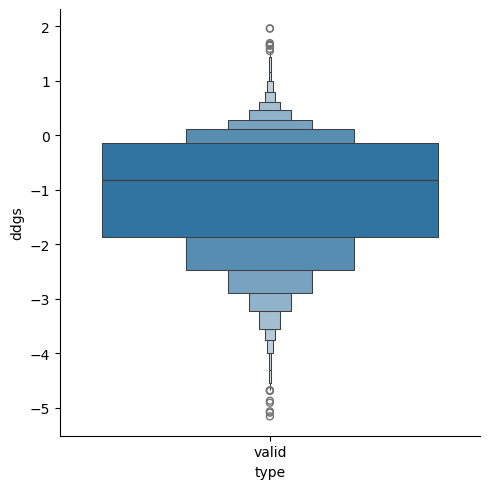

In [172]:
ddgs_list_gt_valid = []
for k, v in wt_ddg_dict_valid.items():
    ddgs_list_gt_valid.extend(v)

dgs_list_gt_valid = []
for k, v in wt_dg_dict_valid.items():
    dgs_list_gt_valid.extend(v)

plot_data = pd.DataFrame({'ddgs': ddgs_list_gt_valid, 'type': ['valid']*len(ddgs_list_gt_valid)})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [175]:
np.min(dgs_list_gt_valid), np.max(dgs_list_gt_valid)

(-0.9969744343395746, 4.907638220759662)

In [154]:
dpo_test_dict_wt = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_test_dict_wt.pkl'), 'rb'))
dg_ml_dict_test = {k: v[3] for k, v in dpo_test_dict_wt.items()}
[k for k, v in dg_ml_dict_test.items() if v > 5]

[]

In [158]:
dpo_test_dict = pickle.load(open(os.path.join(dpo_dict_path, 'dpo_test_dict.pkl'), 'rb'))
high_mut_list_test = []
for k, v in dpo_test_dict.items():
    if v[3] > 5 or v[3] < -1:
        high_mut_list_test.append(k) # 0
hight_mut_wts_test = [dpo_test_dict[k][1] for k in high_mut_list_test]

In [169]:
wt_mut_dict_list_test = {}
for k, v in dpo_test_dict.items():
    wt_name = v[1]
    mut_name = k
    if wt_name not in wt_mut_dict_list_test:
        wt_mut_dict_list_test[wt_name] = [mut_name]
    else:
        wt_mut_dict_list_test[wt_name].append(mut_name)

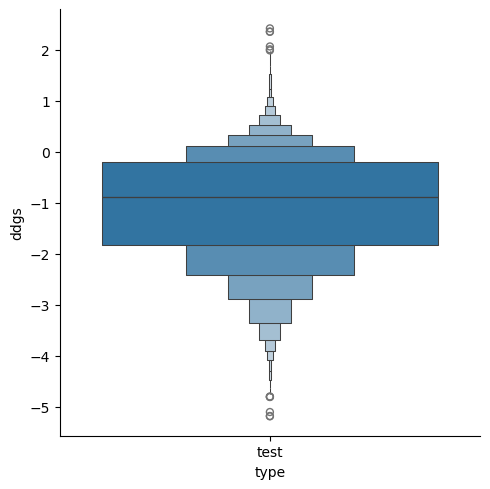

In [171]:
wt_ddg_dict_test = {k: [] for k in wt_mut_dict_list_test.keys()}
wt_dg_dict_test = {k: [] for k in wt_mut_dict_list_test.keys()}
for k, v in dpo_test_dict.items():
    wt_name = v[1]
    wt_ddg_dict_test[wt_name].append(v[3]-v[5])
    wt_dg_dict_test[wt_name].append(v[3])

ddgs_list_gt_test = []
for k, v in wt_ddg_dict_test.items():
    ddgs_list_gt_test.extend(v)

dgs_list_gt_test = []
for k, v in wt_dg_dict_test.items():
    dgs_list_gt_test.extend(v)

plot_data = pd.DataFrame({'ddgs': ddgs_list_gt_test, 'type': ['test']*len(ddgs_list_gt_test)})
fig = sns.catplot(data=plot_data, x = 'type', y =  'ddgs', hue="type", kind="boxen" )

In [174]:
np.min(dgs_list_gt_test), np.max(dgs_list_gt_test)

(-0.9981517152414754, 4.985959077024159)